In [1]:

import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")
!pip install facenet-pytorch --no-deps

!pip install pytubefix


# Clean up the notebook
clean_notebook()

Notebook cleaned.


In [1]:
import cv2
from IPython.display import display, Image, clear_output
import numpy as np
from pytubefix import YouTube
from facenet_pytorch import MTCNN
import torch
import time  # For adding delay

# Initialize MTCNN model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

# YouTube video URL
video_url = "https://youtu.be/EsHQB9gT96k?si=bdi3dDrVnYVIgVYi"
video_url = "https://youtu.be/cmdMopdk6lo?si=vK7azxlZu4PKgiHW"

# Target width for resizing
target_width = 800
# Start and stop times in seconds
start_time = 75  # Start at 10 seconds
end_time = 120   # Stop at 120 seconds

# Download the video stream (use pytubefix to fetch the stream URL)
yt = YouTube(video_url)
video_stream = yt.streams.filter(file_extension='mp4', progressive=True).first()

if not video_stream:
    print("No compatible video stream found.")
    exit()

# Get the stream URL
stream_url = video_stream.url

# Open the YouTube stream in OpenCV
cap = cv2.VideoCapture(stream_url)

if not cap.isOpened():
    print("Cannot open YouTube video stream")
    exit()

# Set start time in the video (in milliseconds)
cap.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)

while cap.isOpened():
    clear_output(wait=True)  # Clear previous frame for smoother playback
    ret, frame = cap.read()
    
    if not ret:
        print("Stream stopped.")
        break

    # Get the current playback time in milliseconds
    current_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000  # Convert to seconds
    
    # Stop playback if the end time is reached
    if current_time >= end_time:
        print("Reached the specified end time.")
        break

    # Convert frame to RGB format
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Detect faces
    boxes, _ = mtcnn.detect(rgb_frame)

    # Draw bounding boxes on the original frame
    if boxes is not None:
        for box in boxes:
            # Extract coordinates
            x1, y1, x2, y2 = map(int, box)
            # Draw rectangle around face
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Get original dimensions
    original_height, original_width = frame.shape[:2]

    # Calculate aspect ratio and new dimensions
    aspect_ratio = original_height / original_width
    new_height = int(target_width * aspect_ratio)

    # Resize the frame while maintaining the aspect ratio
    resized_frame = cv2.resize(frame, (target_width, new_height))

    # Convert the resized frame to JPEG format for display in Jupyter
    _, buffer = cv2.imencode('.jpg', resized_frame)
    img_bytes = buffer.tobytes()

    # Display the resized frame in Jupyter Notebook
    display(Image(data=img_bytes))
  
    # Add a delay for smoother playback
    time.sleep(0.015)  # Delay in seconds

cap.release()
print("Video stream ended.")


Reached the specified end time.
Video stream ended.


# Face panel

In [2]:
import cv2
from IPython.display import display, Image, clear_output
import numpy as np
from pytubefix import YouTube
from facenet_pytorch import MTCNN
import torch
import time

# Initialize MTCNN model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

# YouTube video URL
video_url = "https://youtu.be/EsHQB9gT96k?si=bdi3dDrVnYVIgVYi"
video_url = "https://youtu.be/cmdMopdk6lo?si=vK7azxlZu4PKgiHW"

# Target width for resizing (main video area)
target_width = 800

# Face panel settings
face_panel_width = 150  # Width of the face panel on the right
face_thumbnail_size = 120  # Size of each face thumbnail
max_faces_display = 4  # Number of faces to display vertically

# Start and stop times in seconds
start_time = 75
end_time = 120

# Store recent detected faces
recent_faces = []

# Download the video stream
yt = YouTube(video_url)
video_stream = yt.streams.filter(file_extension='mp4', progressive=True).first()

if not video_stream:
    print("No compatible video stream found.")
    exit()

stream_url = video_stream.url

# Open the YouTube stream in OpenCV
cap = cv2.VideoCapture(stream_url)

if not cap.isOpened():
    print("Cannot open YouTube video stream")
    exit()

# Set start time in the video
cap.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)

def extract_face(frame, box, margin=20):
    """Extract face region from frame with some margin"""
    h, w = frame.shape[:2]
    x1, y1, x2, y2 = map(int, box)
    
    # Add margin
    x1 = max(0, x1 - margin)
    y1 = max(0, y1 - margin)
    x2 = min(w, x2 + margin)
    y2 = min(h, y2 + margin)
    
    face = frame[y1:y2, x1:x2]
    
    if face.size == 0:
        return None
    
    # Resize to square thumbnail
    face_resized = cv2.resize(face, (face_thumbnail_size, face_thumbnail_size))
    return face_resized

def create_face_panel(faces, panel_height):
    """Create a vertical panel with detected faces"""
    # Create dark gray panel
    panel = np.ones((panel_height, face_panel_width, 3), dtype=np.uint8) * 40
    
    # Calculate vertical spacing
    total_face_height = max_faces_display * face_thumbnail_size
    spacing = (panel_height - total_face_height) // (max_faces_display + 1)
    spacing = max(10, spacing)  # Minimum spacing of 10 pixels
    
    # Add title
    cv2.putText(panel, "Detected", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, (255, 255, 255), 1)
    cv2.putText(panel, "Faces", (10, 45), cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, (255, 255, 255), 1)
    
    # Starting y position (after title)
    start_y = 60
    
    # Draw each face
    for i, face in enumerate(faces[:max_faces_display]):
        if face is not None:
            y_pos = start_y + i * (face_thumbnail_size + spacing)
            x_pos = (face_panel_width - face_thumbnail_size) // 2
            
            # Make sure we don't exceed panel bounds
            if y_pos + face_thumbnail_size <= panel_height:
                # Add border around face
                cv2.rectangle(panel, 
                            (x_pos - 2, y_pos - 2), 
                            (x_pos + face_thumbnail_size + 2, y_pos + face_thumbnail_size + 2),
                            (0, 255, 0), 2)
                
                # Place face in panel
                panel[y_pos:y_pos + face_thumbnail_size, 
                      x_pos:x_pos + face_thumbnail_size] = face
                
                # Add face number
                cv2.putText(panel, f"#{i+1}", (x_pos, y_pos - 5), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
    
    return panel

while cap.isOpened():
    clear_output(wait=True)
    ret, frame = cap.read()
    
    if not ret:
        print("Stream stopped.")
        break
    
    current_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000
    
    if current_time >= end_time:
        print("Reached the specified end time.")
        break
    
    # Convert frame to RGB for face detection
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detect faces
    boxes, probs = mtcnn.detect(rgb_frame)
    
    # Process detected faces
    if boxes is not None:
        # Sort by confidence if available, otherwise by size
        if probs is not None:
            # Sort by probability (highest first)
            sorted_indices = np.argsort(probs)[::-1]
            boxes = boxes[sorted_indices]
        
        # Clear recent faces and add new ones
        recent_faces = []
        
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            
            # Draw rectangle on main frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Add face number label
            cv2.putText(frame, f"#{i+1}", (x1, y1 - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            
            # Extract face for panel
            face = extract_face(frame, box)
            if face is not None:
                recent_faces.append(face)
    
    # Get original dimensions
    original_height, original_width = frame.shape[:2]
    
    # Calculate new dimensions for main video
    aspect_ratio = original_height / original_width
    new_height = int(target_width * aspect_ratio)
    
    # Resize the main frame
    resized_frame = cv2.resize(frame, (target_width, new_height))
    
    # Create face panel with matching height
    face_panel = create_face_panel(recent_faces, new_height)
    
    # Combine main frame and face panel horizontally
    combined_frame = np.hstack([resized_frame, face_panel])
    
    # Add timestamp overlay
    cv2.putText(combined_frame, f"Time: {current_time:.1f}s", (10, 30),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Add face count
    face_count = len(recent_faces) if recent_faces else 0
    cv2.putText(combined_frame, f"Faces: {face_count}", (10, 60),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    # Convert to JPEG for display
    _, buffer = cv2.imencode('.jpg', combined_frame)
    img_bytes = buffer.tobytes()
    
    # Display in Jupyter Notebook
    display(Image(data=img_bytes))
    
    # Delay for smoother playback
    time.sleep(0.015)

cap.release()
print("Video stream ended.")

Reached the specified end time.
Video stream ended.


# Face Tracking Implementation

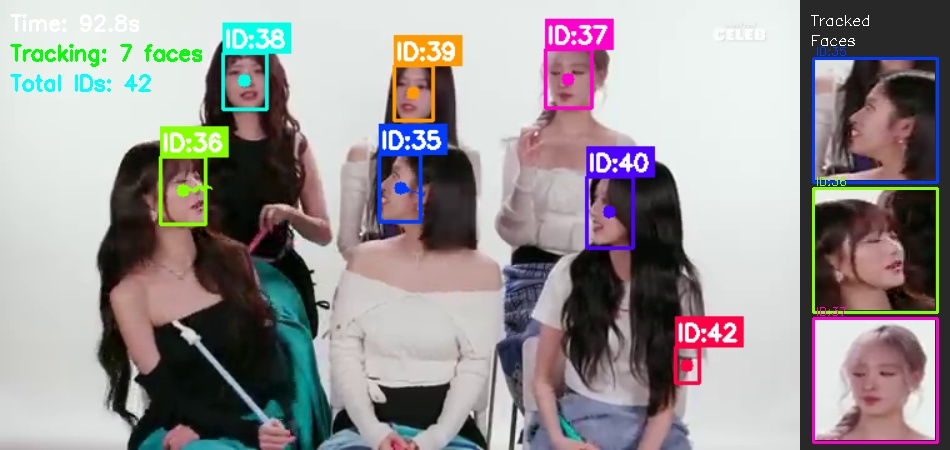

In [ ]:
import cv2
from IPython.display import display, Image, clear_output
import numpy as np
from pytubefix import YouTube
from facenet_pytorch import MTCNN
import torch
import time
from collections import deque

# Initialize MTCNN model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

# YouTube video URL
video_url = "https://youtu.be/EsHQB9gT96k?si=bdi3dDrVnYVIgVYi"
video_url = "https://youtu.be/cmdMopdk6lo?si=vK7azxlZu4PKgiHW"

# Target width for resizing (main video area)
target_width = 800

# Face panel settings
face_panel_width = 150
face_thumbnail_size = 120
max_faces_display = 4

# Start and stop times in seconds
start_time = 75
end_time = 120


class FaceTracker:
    """Simple IoU-based face tracker with trajectory visualization"""
    
    def __init__(self, iou_threshold=0.3, max_disappeared=15, trajectory_length=30):
        self.next_id = 1
        self.tracked_faces = {}  # id -> {'box': box, 'disappeared': count, 'face_img': img, 'trajectory': deque}
        self.iou_threshold = iou_threshold
        self.max_disappeared = max_disappeared
        self.trajectory_length = trajectory_length
        self.colors = {}  # id -> color
    
    def _compute_iou(self, box1, box2):
        """Compute Intersection over Union between two boxes"""
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        
        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        
        union = area1 + area2 - intersection
        
        return intersection / union if union > 0 else 0
    
    def _get_center(self, box):
        """Get center point of a bounding box"""
        return ((box[0] + box[2]) / 2, (box[1] + box[3]) / 2)
    
    def _get_color(self, track_id):
        """Get or generate a unique color for each track ID"""
        if track_id not in self.colors:
            # Generate distinct colors using golden ratio
            hue = (track_id * 0.618033988749895) % 1.0
            # Convert HSV to BGR
            color = cv2.cvtColor(np.uint8([[[hue * 180, 255, 255]]]), cv2.COLOR_HSV2BGR)[0][0]
            self.colors[track_id] = tuple(map(int, color))
        return self.colors[track_id]
    
    def update(self, boxes, face_images):
        """Update tracker with new detections"""
        if boxes is None or len(boxes) == 0:
            # Mark all existing tracks as disappeared
            for track_id in list(self.tracked_faces.keys()):
                self.tracked_faces[track_id]['disappeared'] += 1
                if self.tracked_faces[track_id]['disappeared'] > self.max_disappeared:
                    del self.tracked_faces[track_id]
            return {}
        
        # If no existing tracks, register all detections
        if len(self.tracked_faces) == 0:
            for i, box in enumerate(boxes):
                face_img = face_images[i] if i < len(face_images) else None
                self._register(box, face_img)
        else:
            # Match detections to existing tracks using IoU
            track_ids = list(self.tracked_faces.keys())
            track_boxes = [self.tracked_faces[tid]['box'] for tid in track_ids]
            
            # Compute IoU matrix
            iou_matrix = np.zeros((len(boxes), len(track_boxes)))
            for i, det_box in enumerate(boxes):
                for j, track_box in enumerate(track_boxes):
                    iou_matrix[i, j] = self._compute_iou(det_box, track_box)
            
            # Greedy matching
            matched_detections = set()
            matched_tracks = set()
            
            # Sort by IoU and match greedily
            while True:
                if iou_matrix.size == 0:
                    break
                max_iou = np.max(iou_matrix)
                if max_iou < self.iou_threshold:
                    break
                
                det_idx, track_idx = np.unravel_index(np.argmax(iou_matrix), iou_matrix.shape)
                
                # Update matched track
                track_id = track_ids[track_idx]
                self.tracked_faces[track_id]['box'] = boxes[det_idx]
                self.tracked_faces[track_id]['disappeared'] = 0
                if det_idx < len(face_images) and face_images[det_idx] is not None:
                    self.tracked_faces[track_id]['face_img'] = face_images[det_idx]
                
                # Update trajectory
                center = self._get_center(boxes[det_idx])
                self.tracked_faces[track_id]['trajectory'].append(center)
                
                matched_detections.add(det_idx)
                matched_tracks.add(track_idx)
                
                # Remove matched row and column from consideration
                iou_matrix[det_idx, :] = -1
                iou_matrix[:, track_idx] = -1
            
            # Register unmatched detections as new tracks
            for i, box in enumerate(boxes):
                if i not in matched_detections:
                    face_img = face_images[i] if i < len(face_images) else None
                    self._register(box, face_img)
            
            # Increment disappeared count for unmatched tracks
            for j, track_id in enumerate(track_ids):
                if j not in matched_tracks:
                    self.tracked_faces[track_id]['disappeared'] += 1
                    if self.tracked_faces[track_id]['disappeared'] > self.max_disappeared:
                        del self.tracked_faces[track_id]
        
        return self.tracked_faces
    
    def _register(self, box, face_img):
        """Register a new track"""
        trajectory = deque(maxlen=self.trajectory_length)
        trajectory.append(self._get_center(box))
        
        self.tracked_faces[self.next_id] = {
            'box': box,
            'disappeared': 0,
            'face_img': face_img,
            'trajectory': trajectory
        }
        self.next_id += 1
    
    def draw_trajectories(self, frame):
        """Draw trajectories on frame"""
        for track_id, data in self.tracked_faces.items():
            if data['disappeared'] == 0:  # Only draw active tracks
                trajectory = data['trajectory']
                color = self._get_color(track_id)
                
                # Draw trajectory line
                points = list(trajectory)
                for i in range(1, len(points)):
                    # Fade older points
                    alpha = i / len(points)
                    thickness = max(1, int(3 * alpha))
                    pt1 = tuple(map(int, points[i-1]))
                    pt2 = tuple(map(int, points[i]))
                    cv2.line(frame, pt1, pt2, color, thickness)
                
                # Draw current position marker
                if points:
                    center = tuple(map(int, points[-1]))
                    cv2.circle(frame, center, 5, color, -1)
        
        return frame


def extract_face(frame, box, margin=20):
    """Extract face region from frame with some margin"""
    h, w = frame.shape[:2]
    x1, y1, x2, y2 = map(int, box)
    
    x1 = max(0, x1 - margin)
    y1 = max(0, y1 - margin)
    x2 = min(w, x2 + margin)
    y2 = min(h, y2 + margin)
    
    face = frame[y1:y2, x1:x2]
    
    if face.size == 0:
        return None
    
    face_resized = cv2.resize(face, (face_thumbnail_size, face_thumbnail_size))
    return face_resized


def create_face_panel(tracker, panel_height):
    """Create a vertical panel with tracked faces"""
    panel = np.ones((panel_height, face_panel_width, 3), dtype=np.uint8) * 40
    
    cv2.putText(panel, "Tracked", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(panel, "Faces", (10, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    # Get active faces sorted by ID
    active_faces = [(tid, data) for tid, data in tracker.tracked_faces.items() 
                    if data['disappeared'] == 0 and data['face_img'] is not None]
    active_faces.sort(key=lambda x: x[0])
    
    spacing = 10
    start_y = 60
    
    for i, (track_id, data) in enumerate(active_faces[:max_faces_display]):
        face = data['face_img']
        color = tracker._get_color(track_id)
        
        y_pos = start_y + i * (face_thumbnail_size + spacing)
        x_pos = (face_panel_width - face_thumbnail_size) // 2
        
        if y_pos + face_thumbnail_size <= panel_height:
            # Draw border with track color
            cv2.rectangle(panel, 
                         (x_pos - 2, y_pos - 2), 
                         (x_pos + face_thumbnail_size + 2, y_pos + face_thumbnail_size + 2),
                         color, 2)
            
            panel[y_pos:y_pos + face_thumbnail_size, 
                  x_pos:x_pos + face_thumbnail_size] = face
            
            # Add track ID
            cv2.putText(panel, f"ID:{track_id}", (x_pos, y_pos - 5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
    
    return panel


# Initialize tracker
tracker = FaceTracker(iou_threshold=0.3, max_disappeared=15, trajectory_length=30)

# Download the video stream
yt = YouTube(video_url)
video_stream = yt.streams.filter(file_extension='mp4', progressive=True).first()

if not video_stream:
    print("No compatible video stream found.")
    exit()

stream_url = video_stream.url
cap = cv2.VideoCapture(stream_url)

if not cap.isOpened():
    print("Cannot open YouTube video stream")
    exit()

cap.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)

while cap.isOpened():
    clear_output(wait=True)
    ret, frame = cap.read()
    
    if not ret:
        print("Stream stopped.")
        break
    
    current_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000
    
    if current_time >= end_time:
        print("Reached the specified end time.")
        break
    
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detect faces
    boxes, probs = mtcnn.detect(rgb_frame)
    
    # Extract face images for detected boxes
    face_images = []
    if boxes is not None:
        for box in boxes:
            face_img = extract_face(frame, box)
            face_images.append(face_img)
    
    # Update tracker
    tracked = tracker.update(boxes, face_images)
    
    # Draw tracked faces on frame
    for track_id, data in tracked.items():
        if data['disappeared'] == 0:
            box = data['box']
            x1, y1, x2, y2 = map(int, box)
            color = tracker._get_color(track_id)
            
            # Draw bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            
            # Draw ID label with background
            label = f"ID:{track_id}"
            (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(frame, (x1, y1 - label_h - 10), (x1 + label_w + 5, y1), color, -1)
            cv2.putText(frame, label, (x1 + 2, y1 - 5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    # Draw trajectories
    frame = tracker.draw_trajectories(frame)
    
    # Resize frame
    original_height, original_width = frame.shape[:2]
    aspect_ratio = original_height / original_width
    new_height = int(target_width * aspect_ratio)
    resized_frame = cv2.resize(frame, (target_width, new_height))
    
    # Create face panel
    face_panel = create_face_panel(tracker, new_height)
    
    # Combine frames
    combined_frame = np.hstack([resized_frame, face_panel])
    
    # Add overlays
    cv2.putText(combined_frame, f"Time: {current_time:.1f}s", (10, 30),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    active_count = sum(1 for d in tracked.values() if d['disappeared'] == 0)
    cv2.putText(combined_frame, f"Tracking: {active_count} faces", (10, 60),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    cv2.putText(combined_frame, f"Total IDs: {tracker.next_id - 1}", (10, 90),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
    
    # Display
    _, buffer = cv2.imencode('.jpg', combined_frame)
    img_bytes = buffer.tobytes()
    display(Image(data=img_bytes))
    
    time.sleep(0.015)

cap.release()
print("Video stream ended.")